# Deep Neural Network for Cut Mark Classification

## L. A. Courtenay

Here lies the code and details used to design a Neural Network that differentiates anthropic butchery traces from naturally produced trampling damage on bones. This approach combines Geometric Morphometrics and Deep Learning Feed Forward Neural Networks, as described in:

**L. A. Courtenay, J. Yravedra, R. Huguet and M. Domínguez-Rodrigo (In Prep) A Hybrid Geometric Morphometric Deep Learning Approach for Cut and Trampling Mark Classification, _Submitted to Science Advances_.**

-------------------------------------------------

**_Author_**

Lloyd A. Courtenay

**_Email_**

ladc1995@gmail.com

**_ORCID_**

https://orcid.org/0000-0002-4810-2001

**_Current Affiliations:_**

Universidad Rovira i Virgili (URV)
Institut de Paleoecologia Humana i Evolució Social (IPHES)
TIDOP Group of the Department of Cartographic and Land Engineering (TIDOP)

-------------------------------------------

This Jupyter Notebook is the intelectual property of L. A. Courtenay, and should be cited as **Courtenay (2019) Deep Neural Netowrk for Cut Mark Classification**

--------------------------------------------

Comments, questions, doubts, suggestions and corrections can all be directed to L. A. Courtenay at the email provided above. Science should be a collaborative effort. Archaeology is no exception to this. If any fellow data scientist wishes to improve, contribute, update, report issues or help with this work, please do not hesitate to contact the corresponding author.


# The Code

### Loading Packages

This code requires 5 main packages, plus a sixth library that will be used as a backend engine for the Neural Network to run.

Please ensure you have installed:

- Keras
- Numpy
- Matplotlib
- Pandas
- Scikit-Learn

And either of the following backend engines:
- Tensorflow
- Theano
- CNTK

The algorithm used in this study employed Tensorflow as a backend behind Keras. It is highly recomendable that the user has the Anaconda software installed (https://www.anaconda.com/).

This code is written by an archaeologist, for archaeologists, therefore those unfamiliar with Anaconda, Tensorflow and Python, can consult the following page to find out how to install and set up a Conda environment for deep learning:

https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

Once all the libraries are installed and functional, load the following components:

In [4]:
import os
os.chdir("C:/Users/Lloyd/Desktop/Python Directory/Data") # Set directory

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.constraints import max_norm
import numpy
import pandas
from matplotlib import pyplot
from keras.constraints import unit_norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

Using TensorFlow backend.


## Loading data and Preparing Data

Artificial Neural Networks are stochastic in nature, in order to ensure reproducibility, the following random number generator can be used (but this is optional)

In [5]:
# fix random seed for reproducibility
seed = 100
numpy.random.seed(seed)

Now we need to load the dependencies. A sample of the PC scores used to train the Neural Network is provided on my Github page and can be accessed using the following code:

In [6]:
# load dependencies
dataset = numpy.loadtxt("TMCMtrial.csv", delimiter=",")

Note that the PC scores are loaded into python as a numpy array. These can then be indexed and sliced into training and test sets as follows:

In [7]:
# split into input (X) and output (Y) variables
X = dataset[:,0:10]
Y = dataset[:,10]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed)

Note that the test_size value provides the percentage split, in this case the code is set to 0.3 to divide into **70 % : 30 % Training : Test** ratio.

### Why do we split our data? - Training, Validating and Testing.

In order to efficiently train and validate any type of Deep or Machine Learning model, we have to be able to develop an optimum configuration for the model we wish to use. The tuning of this configuration is called *hyperparameter optimisation*. When the model begins to learn from the data, it produces a feedback signal which can be used to show the model where it went wrong during an iteration when fit on data. This is produced through evaluating the model's performance on validation data (which we will define and split later on in the process).

The model fits itself on the training data, trys to predict the corresponding labels of the validation data, and then evaluates the error produced and uses this error to feed back into the model and adjust the weights. The model will eventually find an optimum combination of weights that reduces this error. The error is known as *loss*. The reason we do three splits; training, validation and testing, is because during the training phenomenon, models that are too complex are likely to *overfit* on both the training and validation data. This overfitting is produced when a model learns both the training and validation data too well, and is unable to generalise when exposed  to new data.

While the model appears to classify data well, in reality when we try to predict the corresponding label values of the test set, we will observe a drastic fall in classification accuracy and the confidence each prediction has.

When we split into training and test sets, the test set is set aside so that when introduced to the model, the model will treat this data as completely unknown information. This avoids what is known as an *information leak*, and thus prevents the model from learning the data too well.

The training split is performed before the training of the model (as we have just done during the previous lines of code). The validation split will be done by the model during the fitting process.

## Creating the Neural Network

Artificial Neural Networks are designed to mimic the human brain. They consist in a series of neurons and connections (synapses) that pass information through the network to obtain a goal. In this case, the Neural Network intends to classify data from data we provide. Our dependencies (variables) will be used to obtain a classification label. The training and use of the network to make predictions uses a number of complex mathematical computations, including components of calculus, linear algebra, statistics and probability theory. In order to obtain the best results, we can use Deep Learning to tune hyperparameters and optimise our results.

The most basic component of our network is the Neuron, which can mathematically be described as:

$$ y(x) = f \left(\sum_{i = 1}^{n} w_{i} x_{i} \right) $$

This single neuron simply calculates all the inputs ($x$) multiplied by the weighted synapses ($w$). The value of $w$ is what the algorithm will optimise during the training process.

The $f()$ refers to an activation function that we can define and modify depending on the type of network we are trying to design. The most frequently used activation functions for binary classification are the *Rectified Linear Unit (ReLU)* for hidden layers and a *sigmoid* function for the output. These can be defined mathematically as:

$$ ReLU = f(x) = max(0,x) $$

$$ Sigmoid = f(x) = \frac{1}{1+e^{-x}} $$

### Keras

While in the past coding and programing a Neural Network required large chunks of code, the powerful open source library Keras carries out this for you, reducing the ammount of programming significantly while still using complex coding beneath it's simplistic outer shell.

In Keras we can begin constructing a model simply through defining the name of the model (here simply titled "model") and defining a **Sequential()** series of layers, that are simply added using the **add()** function. Within each additional layer in this sequence, we specify the number of neurons, the activation and any other hyperparameters we wish to include. In the first layer we also have to include the number of dimensions the model expects as an input.

In the case of the Network used in this study, we additionally include a Dropout() layer, with a threshold of 0.5, which randomly turns 50% of the neurons off per training epoch. This helps generalise during the learning process and reduces overfitting.

The general architecture of the model used in this study is as follows:

In [8]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu', kernel_constraint = unit_norm()))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile the Model

Before the model can be fit to any data, we have to compile it, specifying the loss function we are going to use and how we are going to optimise our weights. In this case, we are dealing with binary classification problems, therefore the loss is set to 'binary_crossentroy'. The optimizer used in this study if the "Adam" algorithm, which can be consulted at:

https://arxiv.org/abs/1412.6980

The compiling of the model is performed via:

In [9]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We can now visualise our model via:

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________
None


For didactic purposes, we have generated a general visualisation of this model:

<img src="Neural Network.tif">

## Training the Neural Network

Now that the model has been defined and compiled, we can train our Neural Network by fitting the model on the data. In order to fit the model on data, we simply use the **fit()** function, defining the training data and corresponding labels. We additionally ask the model to record its progress during the training process in a new data set we define to be called *history*. We next define the validation split, in this case 30% of the training data will be used to evaluate the model during training and adjust the weights, and finally we provide the number of epochs and batch size.

A single epoch is defined as *the passing of an entire dataset through a neural network only once*. This is an iterative process, therefore the number of times this process is repeated is defined by the analyst. In this case, the optimal number of epochs has been defined as 900.

The batch size is the number of training examples used in one epoch iteration. There are a number of different types of batch size. In this study the optimum batch size and type is a mini-batch using 64 samples.

The number of batches and epochs is a hyperparameter that is often fine tuned when trying to optimise model performance. If the number of epochs are too high, overfitting is likely to occur. The batch size also has an influence on how well the model learns the data. We thus need to find the optimum combination of these two features that allows the model to sufficiently learn the patterns presented within the data, but not too much.

The code to fit the model is:

In [19]:
# Fit the model
history = model.fit(X_train, Y_train, validation_split=0.30, epochs=900, batch_size=64, verbose=0)

## Model Evaluation

We can now evaluate our model and print out the average accuracy obtained:

In [20]:
scores = model.evaluate(X_train, Y_train) # Print Accuracy
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

700/700 [==============================] - 0s 0us/step

acc: 100.00%


We can plot out a learning curve, observing how the model's accuracy and loss evolved throughout the training process. These plots record the accuracy or loss of the model over each epoch. We can detect over or underfitting by observing how the model performs on the validation and train sets. An optimum model will present both curves peaking at the same time.

The curves are plot as follows:

### Accuracy

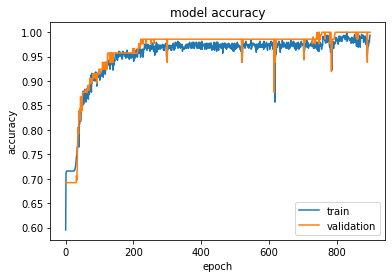

In [13]:
# Accuracy Plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

### Loss

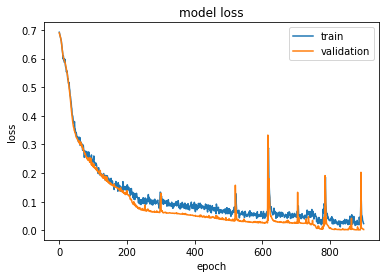

In [14]:
# Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluating on the Test Set

Now we can use our model to predict the labels of the test set, evaluating the accuracy when used to predict new data:

In [15]:
#Once hyperparameters are tuned, the final model is used to predict the test-set
predictions = model.predict(X_test)
rounded = [round(x[0]) for x in predictions]
accuracy = numpy.mean(rounded == Y_test)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

Prediction Accuracy: 100.00%


Finally we can obtain values of sensitivity, specificity and the kappa statistic via confusion matrices. These different values are calculated considering the number of correctly and incorrectly classified samples. The values produced are known as true positive, true negative, false positive and false negative rates. A classic example of a false positive is found in medical practices, whereby a patient is predicted to have a disease when they are actually healthy. A true positive would be when the patient has the disease and is correctly predicted to have the disease (and so on...).

A kappa value of $ k > 0.8 $ is considered a powerful predictive model.

Sensitivity and specificity values of 1 indicate that the model makes no mistakes while a value of 0 indicates a high number of misclassified samples.

These three values can be calculated via:

In [18]:
# Model evaluation in test data
# Kappa
K = cohen_kappa_score(Y_test, rounded)
# Sensitivity and Specificity
confusion = confusion_matrix(Y_test,rounded)
TP = confusion[1, 1] # True Positives
TN = confusion[0, 0] # True Negatives
FP = confusion[0, 1] # False Positives
FN = confusion[1, 0] # False Negatives
print(" ", "\n Sensitivity: ", TP / float(TP + FN), "\n Specificity: ", TN / float(TN + FP), "\n Kappa: ", K, "\n ")

  
 Sensitivity:  1.0 
 Specificity:  1.0 
 Kappa:  1.0 
 


Finally we can visualise the specificity : sensitivity ratio through what is known as a Receiver Operating Characteristic curve (ROC). ROCs plot the true positive rate against the false positive rate, ie: a plot of sensitivity against specificity. The closer the curve is to the top left corner, the more powerful the model. If the plot presents a diagonal line, then the model is a very poor classifier. We can quantify this trend by calculating the area under the ROC curve, simply known as the Area Under Curve (AUC) value. A value of 1 indicates that the model has correctly classified all samples. A value of 0 indicates the contrary.

We can plot the ROC and calculate the AUC via:

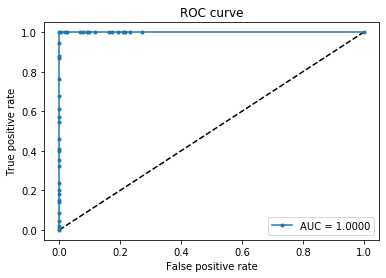

In [16]:
# Plot ROC Curves
probs = model.predict_proba(X_test)
# calculate AUC amd ROC Curve Values
auc = roc_auc_score(Y_test, probs)
fpr, tpr, thresholds = roc_curve(Y_test, probs)
# Produce plot
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr, marker = ".", label='AUC = {:.4f}'.format(auc))
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('ROC curve')
pyplot.legend(loc='best')
# show the plot
pyplot.show()

# Conclusions

This code was written to try and provide an introduction of neural networks and deep learning for archaeologists. Deep learning is a complex field and the contents of this notebook has only scratched the surface of the potential neural networks may hold. It is important to point out the following:

- This code has proven succesful in this study, however a number of factors have to be highlighted if other analysts wish to perform similiar studies
    - Deep Learning Neural Networks are versatile and can be found in many different forms. While this network worked for the classification of cut and trampling samples in our study, the model may not work for the classification of cut mark samples produced by different raw materials, for example. The analyst should adjust their model according to the data they have.
    - This means that the analyst should:
        - Use an experimental sample produced by the raw material and tool types of their site
        - Adjust the neural network architecture to their data to obtain the best results fit to their own data sets.
    - The model in this study, therefore, is to be used as inspiration, or a general example of a model that has worked for our particular case study.
    
## Further Reading - Articles

For further reading about components used within this study, consult:

- D. P. Kingma, J. L. Ba, Adam: a Method for Stochastic Optimization, 3rd International Conference for Learning Representations, San Diego. ArXiv: 1412.6980 (2015)

## Further Reading - Books

For further reading about Neural Networks and Deep Learning, we strongly recomend the following books:

- F. Chollet, *Deep Learning with Python.* (Manning, New York, 2017)
- J. Brownlee, *Deep Learning with Python. Develop Deep Learning Models on Theano and Tensorflow Using Keras* (Machine Learning Mastery, Melbourne, 2016)

For further reading about hyperparameter optimisation, we strongly recomend:

- J. Brownlee, *Better Deep Learning: Train Faster, Reduce Overfitting and Make Better Predictions.* (Machine Learning Mastery, Melbourne, 2019)

For general practices in Machine and Deep Learning, we strongly recomend:

- M. Kuhn, K. Johnson, *Applied Predictive Modelling.* (Springer, New York, 2013)

For the mathematics of Deep Learning and Neural Networks, we recomend:

- J. Heaton, *Introduction to the Math of Neural Networks.* (Missouri, Heaton Research Inc., 2012)
- A.C.C. Coolen, A Beginner's Guide to the Mathematics of Neural Networks, *Concepts for Neural Networks* (Springer, London, 1998) p.p. 13-70
- C.M. Bishop, *Neural Networks for Pattern Recognition* (Clarendon Press, Oxford, 1995)

Once again, this brief bibliography only scratches the surface of the field of Machine Learning, Deep Learning and Aritifical Intelligence. If interested in more, do not hesitate to contact the corresponding author:

Lloyd A. Courtenay - ladc1995@gmail.com